In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [6]:
import src.random_data_generator as rdg

rdg.generate_random_points(100, 50, 0, 1, 2)

array([[-1.59073305e+01,  7.50615086e-01, -2.45027179e+00, ...,
        -4.94813658e-02, -2.10029179e+00, -3.53491005e-01],
       [-1.66524123e+01,  1.81937816e+00, -2.48991813e+00, ...,
         5.67126339e-01, -9.28262956e-01, -2.00485254e+00],
       [ 1.77451046e+00,  1.11277416e+02,  7.80310882e-01, ...,
        -4.79171454e-02,  1.29297570e+00,  2.25466367e+00],
       ...,
       [-2.70202977e+00,  3.12596645e+00,  2.29274778e+00, ...,
        -9.26308159e-01, -9.59544746e+00,  1.78096848e+00],
       [-1.17468557e+01,  1.29151823e+00,  8.12038389e-01, ...,
        -1.07044727e+00, -3.43118785e-01,  2.47431857e+00],
       [ 7.99562607e+00,  1.27696770e+00, -3.10831072e-01, ...,
         2.82310401e+00,  8.84646649e-01, -3.36399103e+00]])

box muller

In [7]:
def exp_q(x: np.array, q: float) -> np.array:
    return (1 + (1 - q) * x) ** (1 /(1 - q))

def A_q_func(q: float) -> float:
    if q == 1:
        return np.sqrt(2 * np.pi)
    elif 1 < q < 3:
        return np.sqrt((3 - q)/(q - 1)) * np.random.beta((3 - q)/(2 * (q - 1)), 1/2)
    
def f_q(q: int, x:np.array, mu: float, sigma: float) -> np.array:
    return (1 / A_q_func(q)) * exp_q(-((x - mu)**2/((3 - q) * sigma**2)), q)

In [8]:
def ln_q(x: np.array, q: float) -> np.array:
    result = np.zeros(x.size)
    for ind in range(x.size):
        if x[ind] <= 0:
            print("Undefined: There is a number less than or equal to 0")
            break
        elif x[ind] > 0 and q == 1:
            result[ind] = np.log(x[ind])
        elif x[ind] > 0 and q != 1:
            result[ind] = (x[ind] ** (1-q) - 1) / (1 - q)
        else:
            print("The conditions were not met")

    return result

def box_muller(mu: float, sigma: float, q: float, size: int) -> np.array:
    U1 = np.random.uniform(0, 1, size)
    U2 = np.random.uniform(0, 1, size)

    q_prime = (1 + q) / (3 - q)
    beta = 1 / (2 * sigma ** 2)

    Z = np.sqrt(-2*ln_q(U1, q_prime)) * np.cos(2 * np.pi * U2)

    Z_prime = mu + Z / (np.sqrt(beta * (3-q)))

    return Z_prime

def random_q_gaussian(mu: float, sigma: float, q: float, size: int):
    if q == 1:
        return np.random.normal(mu, sigma, size)
    elif 1 < q < 3:
        return mu + sigma * np.sqrt(2/(3 - q)) * np.random.standard_t((1+q)/(3-q), size)
    else:
        raise("Invalid value for q")

In [9]:
def mu_hat(x: np.matrix) -> np.array:
    return x.mean(axis=1)

def sigma_hat(x: np.matrix) -> np.array:
    return x.std(axis=1)

def q_fisher(sigma: np.array, q: float) -> np.array:
    A_q = A_q_func(q)
    q_fisher_matrix = []
    for i in range(sigma.size):
        matrix = np.zeros((2, 2))
        matrix[0, 0] = 2/((3-q) * (A_q ** (1 -q)) * (sigma[i] ** (3 - q)))
        matrix[1, 1] = 2/((A_q ** (1 -q)) * (sigma[i] ** (3 - q)))
        q_fisher_matrix.append(matrix)

    return np.array(q_fisher_matrix)

In [10]:
Z1 = random_q_gaussian(0, np.sqrt(1/(2 * 1)), 1, 10000)
Z2 = random_q_gaussian(0, np.sqrt(1/(2 * 1)), 2, 10000)
Z3 = random_q_gaussian(0, np.sqrt(1/(2 * 3)), 2, 10000)

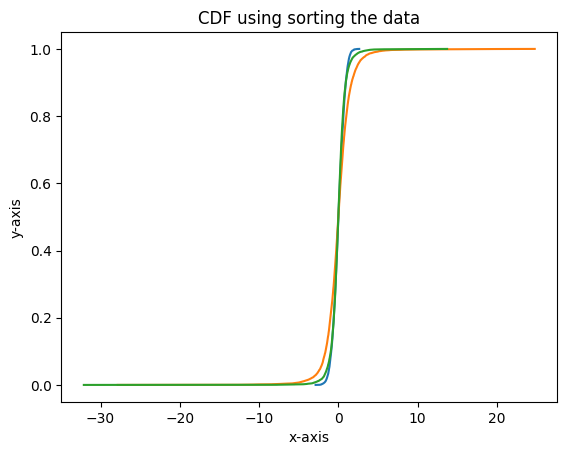

In [11]:
# sort the data in ascending order 
Z1_ordered = np.sort(Z1)
Z2_ordered = np.sort(Z2)
Z3_ordered = np.sort(Z3)
  
# get the cdf values of y 
y = np.arange(10000) / float(10000)
  
# plotting 
plt.xlabel('x-axis')
plt.ylabel('y-axis')
  
plt.title('CDF using sorting the data') 
  
plt.plot(Z1_ordered, y)
plt.plot(Z2_ordered, y)
plt.plot(Z3_ordered, y) 

[Text(0.5, 1.0, 'Kernel density estimation')]

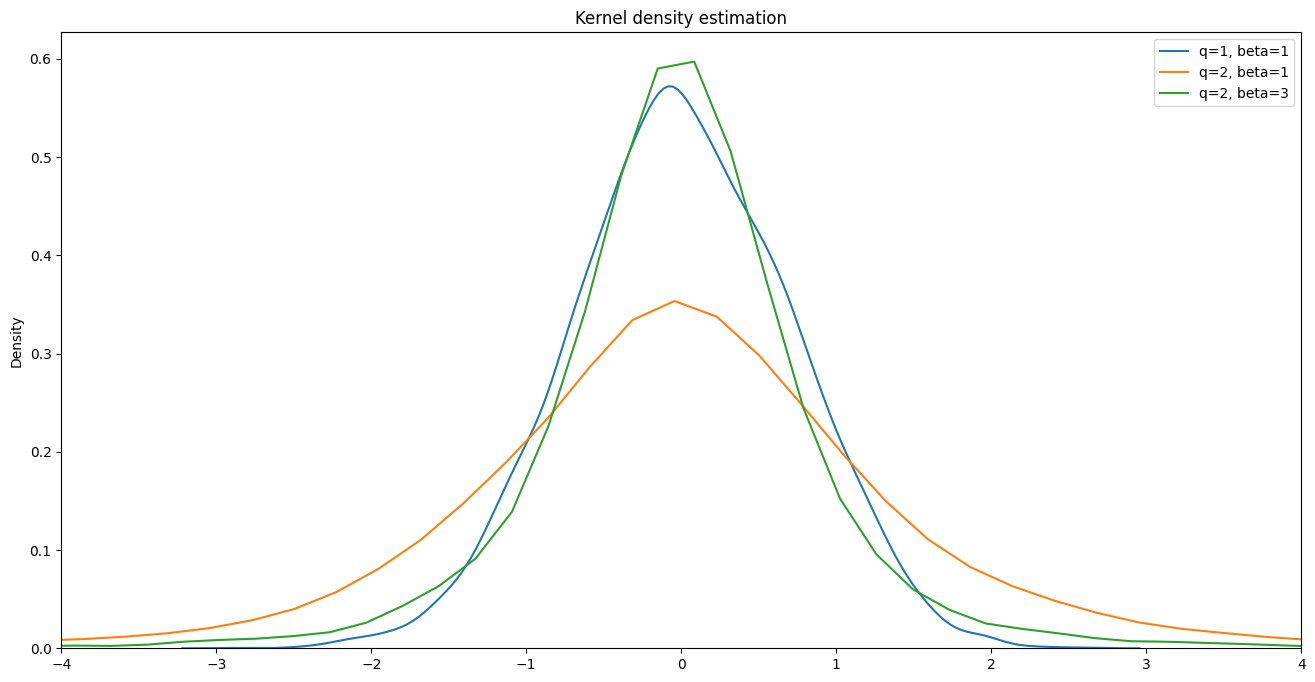

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.kdeplot(Z1, label=f"q={1}, beta={1}")
sns.kdeplot(Z2, label=f"q={2}, beta={1}")
sns.kdeplot(Z3, label=f"q={2}, beta={3}")
plt.xlim(-4, 4)
plt.legend()
ax.set(title="Kernel density estimation")

In [13]:
# from scipy.stats import kstest, jarque_bera

# #perform Kolmogorov-Smirnov test
# print(kstest(Z, 'norm'),
#       jarque_bera(Z),
#       sep="\n")

In [14]:
dimension = 50
num_points = 100

F_1 = np.zeros((num_points, dimension))
F_2 = np.zeros((num_points, dimension))
for i in range(100):
    F_1[i, :] = box_muller(mu=0, sigma=1, q=2, size=50)
    F_2[i, :] = box_muller(mu=2, sigma=2, q=2, size=50)

family_1 = pd.DataFrame({"mu_hat": mu_hat(F_1), "sigma_hat": sigma_hat(F_1), "label": [1]*num_points})
family_2 = pd.DataFrame({"mu_hat": mu_hat(F_2), "sigma_hat": sigma_hat(F_2), "label": [2]*num_points})
df = pd.concat([family_1, family_2], axis=0, ignore_index=True)
df["label"] = df["label"].astype(str)

In [15]:
color_discrete_map = {
    "1": 'blue',
    "2": 'red',
}

symbol_map = {
    "1": 'circle',
    "2": 'x',
}

fig = px.scatter(
    df,
    x="mu_hat",
    y="sigma_hat",
    color="label",
    color_discrete_map=color_discrete_map,
    symbol='label',
    symbol_map=symbol_map,
    )
fig.update_layout(
    plot_bgcolor='white',  # Establece el fondo blanco
)

In [16]:
q_fisher_information_matrix = q_fisher(df["sigma_hat"].to_numpy(), 2)

In [17]:
np.zeros((2, 2))

array([[0., 0.],
       [0., 0.]])